[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ibrahim-ince/BrainTumorClassification/blob/main/15_Classes/F15_Birlestirme.ipynb)

In [ ]:
!pip install tensorflow==2.9.0

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.9.0


In [ ]:
!mkdir data
!unzip "/content/drive/MyDrive/TumorSiniflandirma/archive.zip" -d "/content/data/"

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import cv2
import albumentations as A
import shutil

from keras import regularizers
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Activation, Add, GlobalAveragePooling2D, MaxPooling2D, Input, Flatten
from keras.regularizers import l1_l2
from keras.models import Model
from keras.optimizers import Adam, Adamax, Nadam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/train.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/valid.csv")
test_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/test.csv")

In [ ]:
def to15(df):
    image_paths = []
    labels = []
    for path, label in zip(df['image_path'], df['label']):
        image_paths.append(path)
        labels.append(label.split(" ")[0])
    pd_df = pd.DataFrame({
        'image_path' : image_paths,
        'label' : labels
    })
    return pd_df

In [ ]:
train_df = to15(train_df)
valid_df = to15(valid_df)
test_df = to15(test_df)

In [ ]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=False, palette='winter'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

In [ ]:
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 16

test_length = len(test_df)
test_batch_size = sorted([int(test_length / n) for n in range(1, test_length + 1) if test_length % n == 0 and test_length / n <= 80], reverse=True)[0]  
test_steps = int(test_length / test_batch_size)   

In [ ]:
train_gen = ImageDataGenerator()

test_gen = ImageDataGenerator()

train_gen = train_gen.flow_from_dataframe(train_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= color, 
                                    shuffle= True, 
                                    batch_size= batch_size)

valid_gen = test_gen.flow_from_dataframe(valid_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= color, 
                                    shuffle= False, 
                                    batch_size= batch_size)

test_gen = test_gen.flow_from_dataframe(test_df, 
                                   x_col= 'image_path', 
                                   y_col= 'label', 
                                   target_size= img_size, 
                                   class_mode= 'categorical',
                                   color_mode= color, 
                                   shuffle= False, 
                                   batch_size= test_batch_size)

Found 3134 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [ ]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# this is the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return

def predictor(model,test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    cm = confusion_matrix(ytrue, ypred )
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

def print_errors(error_list,error_pred_list, delimiter):
    if len(error_list) == 0:
        print('There were no errors in predicting the test set')
    else:
        if len(error_list)>500:
            print('There were over 50 misclassifications, the error list will not be printed')
        else:
            print('Below is a list of test files that were miss classified \n')
            print('{0:^50s}{1:^50s}'.format('Test File', ' Predicted as'))            
            for i in range(len(error_list)):
                fpath=error_list[i]                
                split=fpath.split(delimiter)                 
                slength=len(split)
                f=split[slength-2].split(" ")[0]   
                print(f'{f:^50s}{error_pred_list[i]:^50s}')

def plot_errors_vs_class(error_list, delimiter):
    if len(error_list)==0:
        return 
    error_classes=[]
    for i in range(len(error_list)):
                fpath=error_list[i]                
                split=fpath.split(delimiter)
                slength=len(split)                
                klass= split[slength-2].split(" ")[0]                
                if klass not in error_classes:
                    error_classes.append(klass)   
    error_classes=sorted(error_classes, reverse=True)    
    error_count= [0 for i in range(len(error_classes))]
    for  i in range (len(error_classes)):
        eklass=error_classes[i]    
        for fpath in error_list:
            split=fpath.split(delimiter)
            slength=len(split)
            fklass= split[slength-2].split(" ")[0]
            if eklass == fklass:
                error_count[i] +=1
    fig=plt.figure()
    L=len(error_classes)
    if (L)<= 10:
        fig.set_figheight(L)
    elif L >10 and  L <=20:
        fig.set_figheight(int(len(error_classes)/2))
    else:
        fig.set_figheight(int(len(error_classes)/2.5))
    fig.set_figwidth(12)
    plt.style.use('fivethirtyeight')
    plt.barh(error_classes, error_count)
    plt.title( ' Classification Errors on Test Set by Class')
    plt.show()
    return error_classes, error_count

def print_error_rate(error_classes, error_count, test_df):
    value_counts = []
    for i in range(len(error_classes)):
         value_counts.append((test_df['label'].values == error_classes[i]).sum())
    error_rates = [0 for i in range(len(error_classes))]
    for i in range(len(error_classes)):
        error_rates[i] = (error_count[i] / value_counts[i]) * 100
    fig=plt.figure()
    L=len(error_classes)
    if (L)<= 10:
        fig.set_figheight(L)
    elif L >10 and  L <=20:
        fig.set_figheight(int(len(error_classes)/2))
    else:
        fig.set_figheight(int(len(error_classes)/2.5))
    fig.set_figwidth(12)
    plt.style.use('fivethirtyeight')
    plt.barh(error_classes, error_rates)
    plt.title( ' Classification Error Rates on Test Set by Class')
    plt.show()

Model 41

In [ ]:
model1 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_32.h5", custom_objects={"F1_score": F1_score})
model2 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_34.h5", custom_objects={"F1_score": F1_score})
model1._name = "model_1"
model2._name = "model_2"
models = [model1, model2]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model1 = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model1.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', F1_score, 'AUC'])

In [ ]:
train_score = ensemble_model1.evaluate(train_gen, verbose= 1)
valid_score = ensemble_model1.evaluate(valid_gen, verbose= 1)
test_score = ensemble_model1.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train F1-score: ", train_score[2])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Validation F1-score: ", valid_score[2])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test F1-score: ", test_score[2])

12/12 [==============================] - 7s 500ms/step - loss: 0.3449 - accuracy: 0.9836 - F1_score: 0.9851 - auc: 0.9991
Train Loss:  0.2874028980731964
Train Accuracy:  1.0
Train F1-score:  1.0
--------------------
Validation Loss:  0.3129505217075348
Validation Accuracy:  0.9940476417541504
Validation F1-score:  0.9939516186714172
--------------------
Test Loss:  0.3448638916015625
Test Accuracy:  0.9836309552192688
Test F1-score:  0.9850519299507141


12/12 [==============================] - 11s 329ms/step
there were 11 errors in 672 tests for an accuracy of  98.36


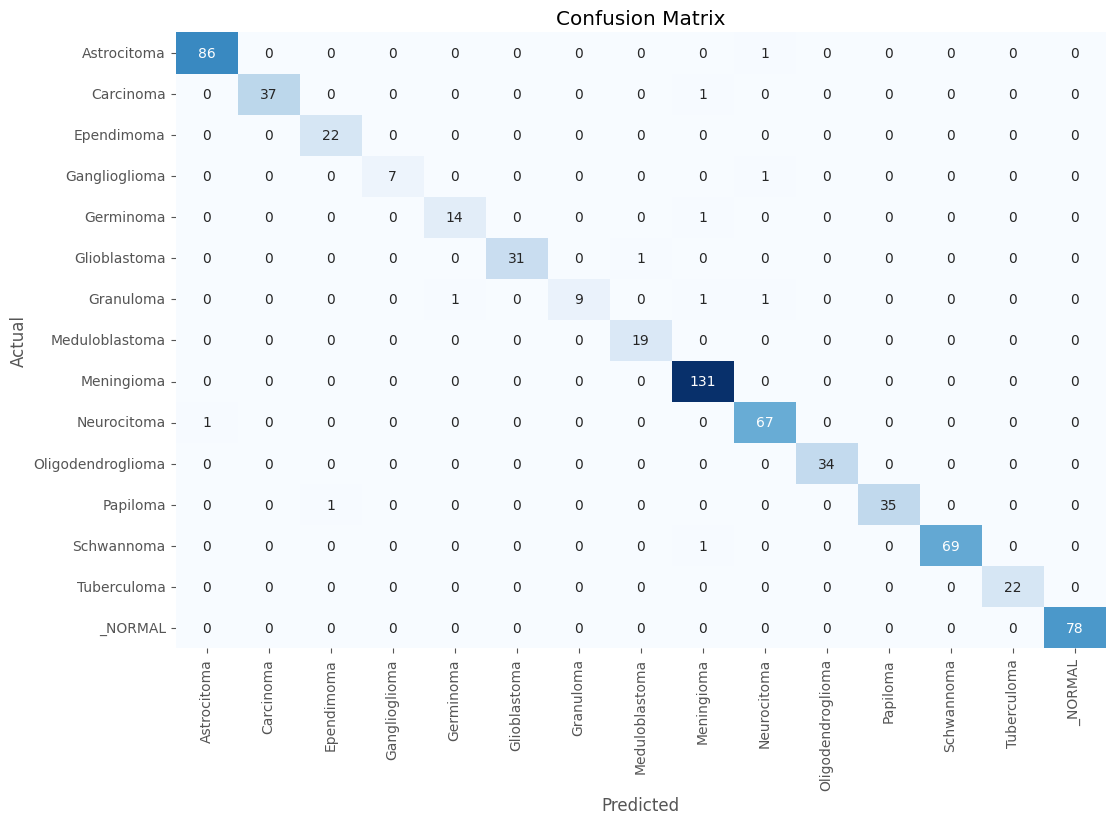

Classification Report:
----------------------
                    precision    recall  f1-score   support

      Astrocitoma     0.9885    0.9885    0.9885        87
        Carcinoma     1.0000    0.9737    0.9867        38
       Ependimoma     0.9565    1.0000    0.9778        22
    Ganglioglioma     1.0000    0.8750    0.9333         8
        Germinoma     0.9333    0.9333    0.9333        15
     Glioblastoma     1.0000    0.9688    0.9841        32
        Granuloma     1.0000    0.7500    0.8571        12
   Meduloblastoma     0.9500    1.0000    0.9744        19
       Meningioma     0.9704    1.0000    0.9850       131
      Neurocitoma     0.9571    0.9853    0.9710        68
Oligodendroglioma     1.0000    1.0000    1.0000        34
         Papiloma     1.0000    0.9722    0.9859        36
       Schwannoma     1.0000    0.9857    0.9928        70
      Tuberculoma     1.0000    1.0000    1.0000        22
          _NORMAL     1.0000    1.0000    1.0000        78

       

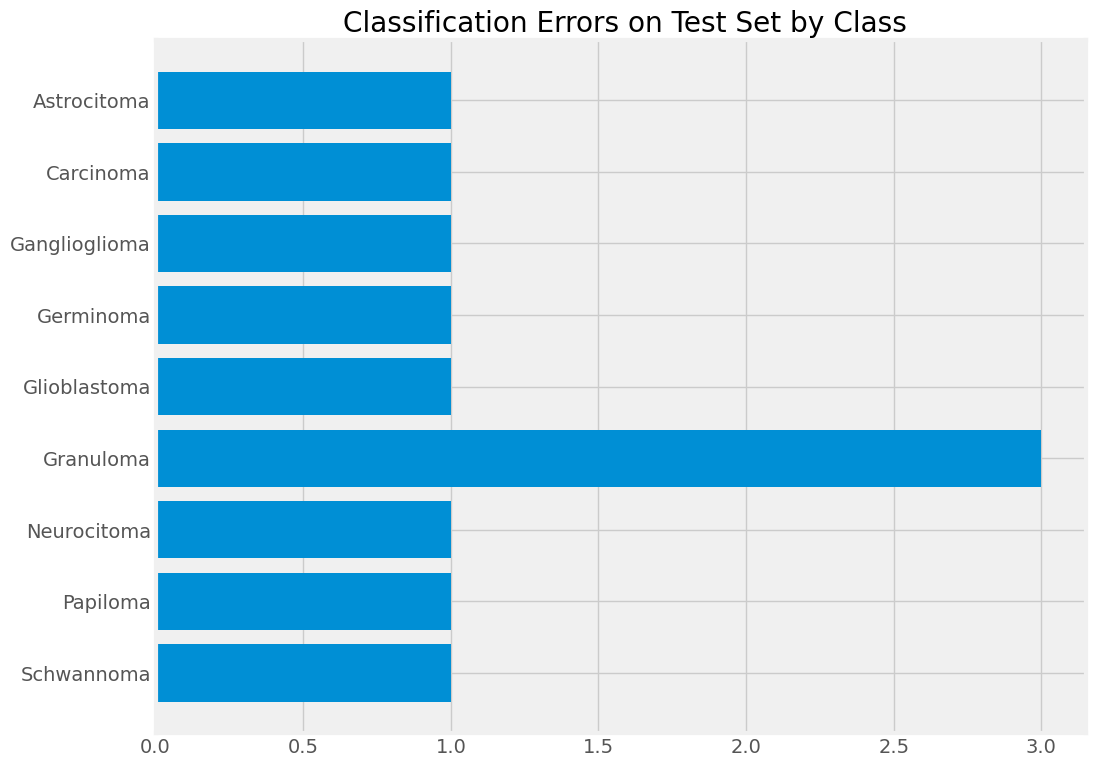

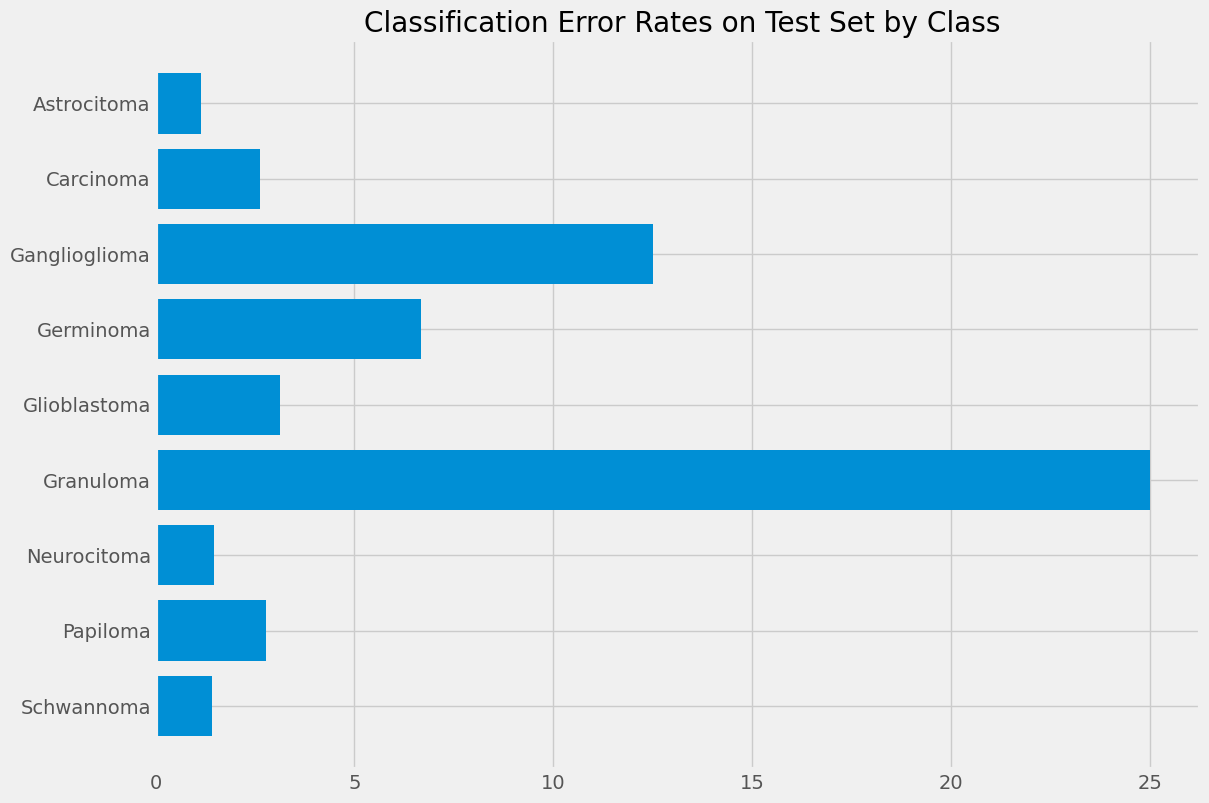

In [ ]:
delimiter = '/'
errors, tests, error_list, error_pred_list, f1score = predictor(ensemble_model1, test_gen)
print_errors(error_list, error_pred_list, delimiter)
error_classes, error_count = plot_errors_vs_class(error_list, delimiter)
print_error_rate(error_classes, error_count, test_df)

Model 42

In [ ]:
model1 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_34.h5", custom_objects={"F1_score": F1_score})
model2 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_39.h5", custom_objects={"F1_score": F1_score})
model1._name = "model_1"
model2._name = "model_2"
models = [model1, model2]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model2 = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model2.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', F1_score, 'AUC'])

In [ ]:
train_score = ensemble_model2.evaluate(train_gen, verbose= 1)
valid_score = ensemble_model2.evaluate(valid_gen, verbose= 1)
test_score = ensemble_model2.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train F1-score: ", train_score[2])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Validation F1-score: ", valid_score[2])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test F1-score: ", test_score[2])

12/12 [==============================] - 5s 305ms/step - loss: 0.3280 - accuracy: 0.9836 - F1_score: 0.9850 - auc: 0.9997
Train Loss:  0.2593250572681427
Train Accuracy:  1.0
Train F1-score:  1.0
--------------------
Validation Loss:  0.2922714650630951
Validation Accuracy:  0.9940476417541504
Validation F1-score:  0.9931834936141968
--------------------
Test Loss:  0.32799971103668213
Test Accuracy:  0.9836309552192688
Test F1-score:  0.9849559664726257


12/12 [==============================] - 12s 313ms/step
there were 11 errors in 672 tests for an accuracy of  98.36


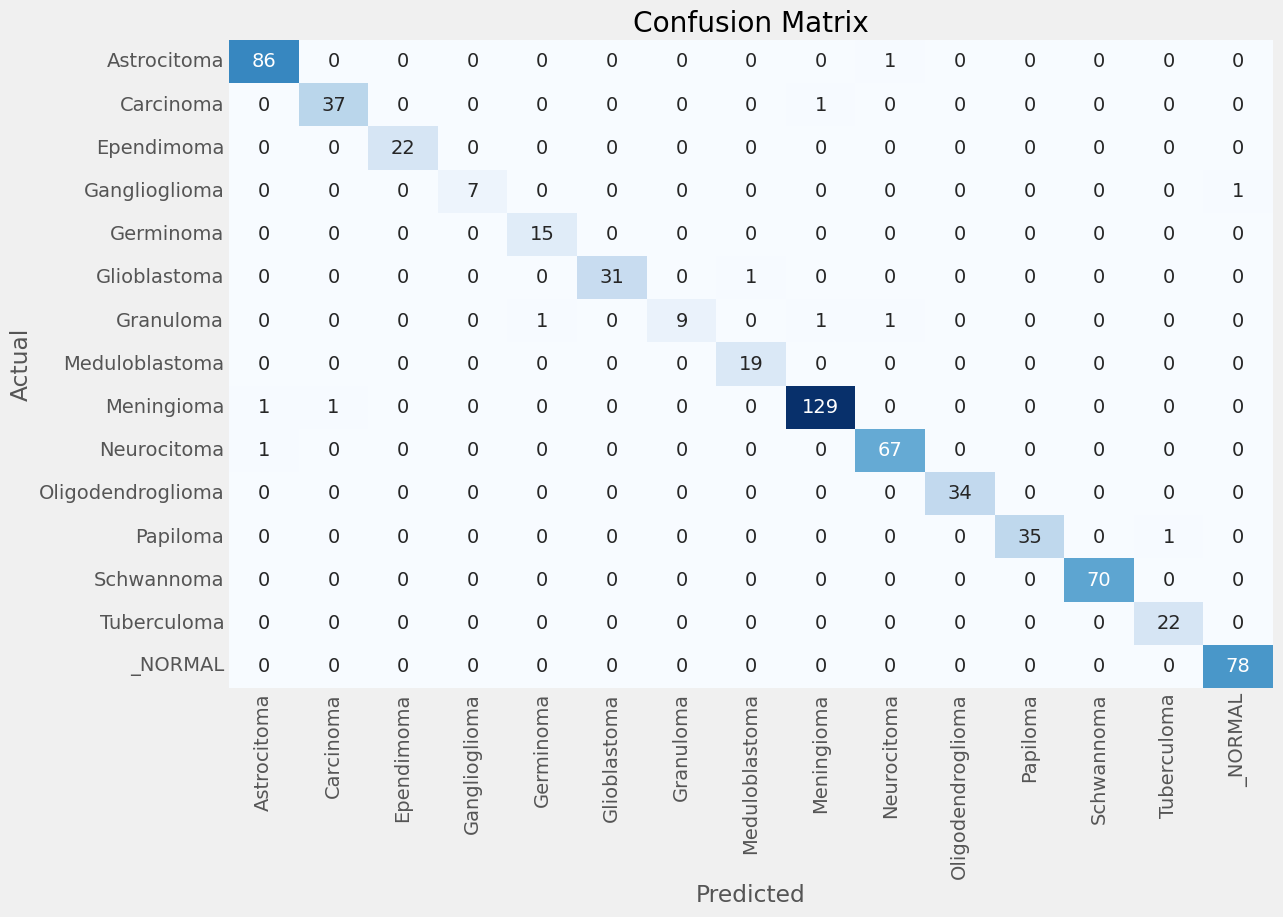

Classification Report:
----------------------
                    precision    recall  f1-score   support

      Astrocitoma     0.9773    0.9885    0.9829        87
        Carcinoma     0.9737    0.9737    0.9737        38
       Ependimoma     1.0000    1.0000    1.0000        22
    Ganglioglioma     1.0000    0.8750    0.9333         8
        Germinoma     0.9375    1.0000    0.9677        15
     Glioblastoma     1.0000    0.9688    0.9841        32
        Granuloma     1.0000    0.7500    0.8571        12
   Meduloblastoma     0.9500    1.0000    0.9744        19
       Meningioma     0.9847    0.9847    0.9847       131
      Neurocitoma     0.9710    0.9853    0.9781        68
Oligodendroglioma     1.0000    1.0000    1.0000        34
         Papiloma     1.0000    0.9722    0.9859        36
       Schwannoma     1.0000    1.0000    1.0000        70
      Tuberculoma     0.9565    1.0000    0.9778        22
          _NORMAL     0.9873    1.0000    0.9936        78

       

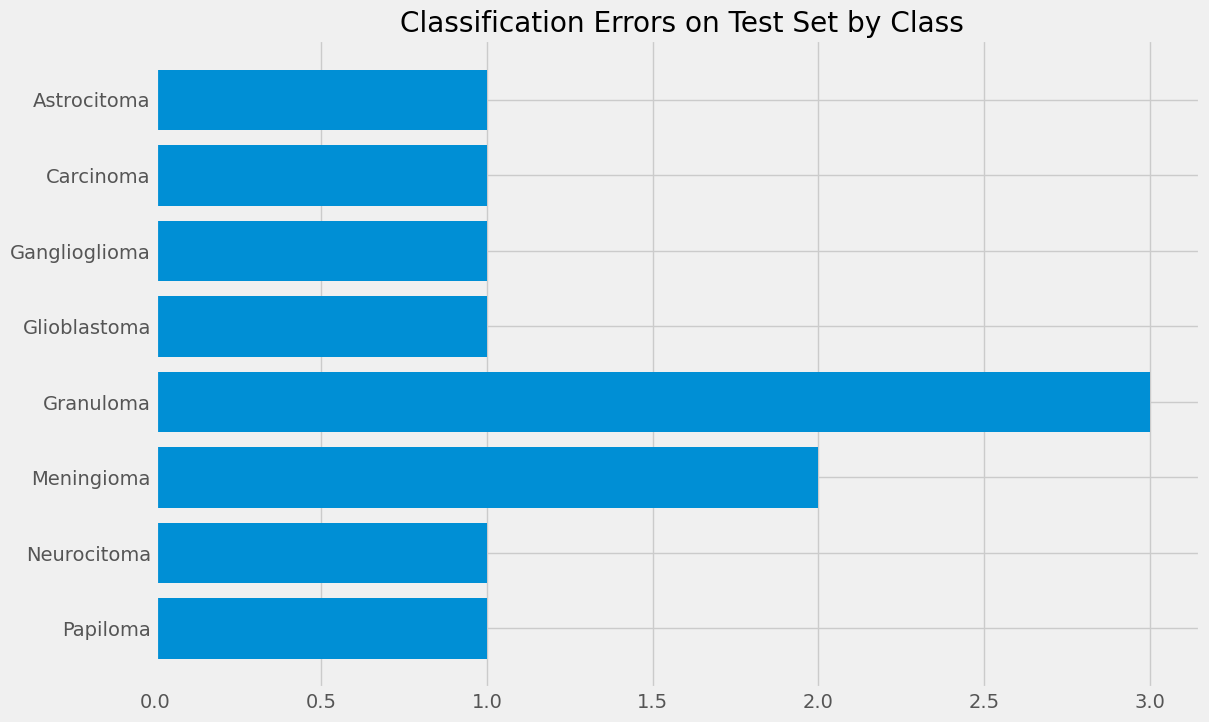

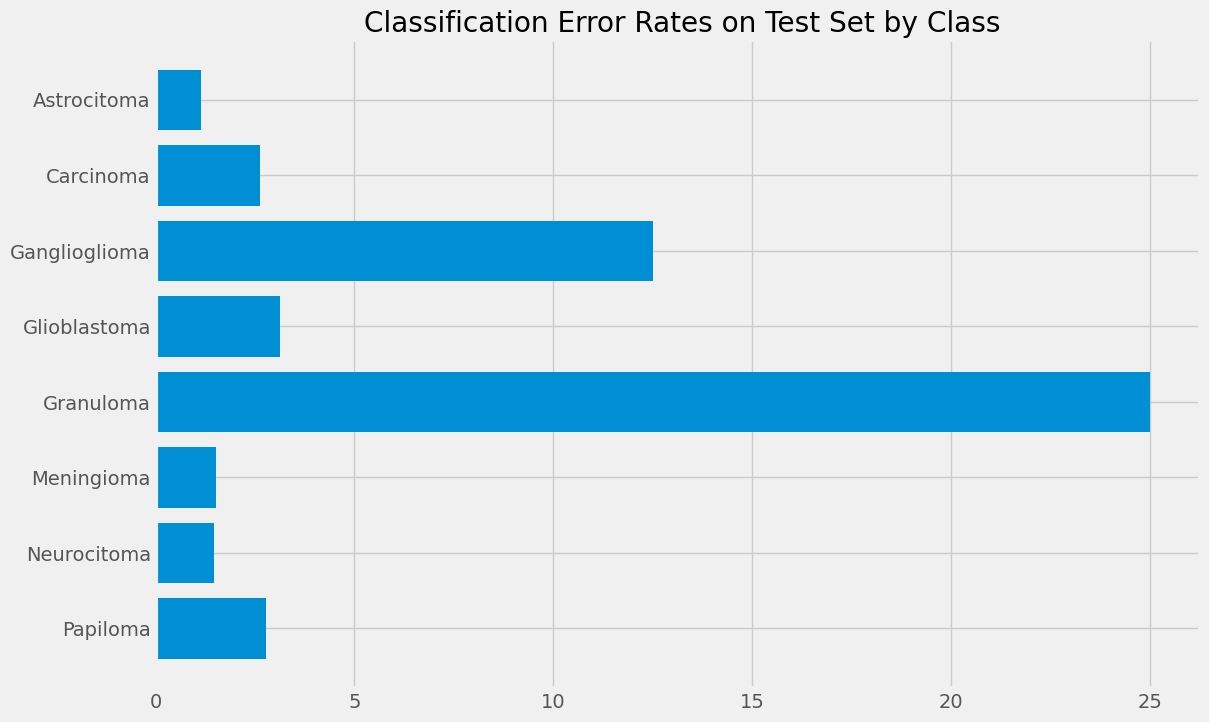

In [ ]:
delimiter = '/'
errors, tests, error_list, error_pred_list, f1score = predictor(ensemble_model2, test_gen)
print_errors(error_list, error_pred_list, delimiter)
error_classes, error_count = plot_errors_vs_class(error_list, delimiter)
print_error_rate(error_classes, error_count, test_df)

Model 43

In [ ]:
model1 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_32.h5", custom_objects={"F1_score": F1_score})
model2 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_39.h5", custom_objects={"F1_score": F1_score})
model1._name = "model_1"
model2._name = "model_2"
models = [model1, model2]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model3 = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model3.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', F1_score, 'AUC'])

In [ ]:
train_score = ensemble_model3.evaluate(train_gen, verbose= 1)
valid_score = ensemble_model3.evaluate(valid_gen, verbose= 1)
test_score = ensemble_model3.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train F1-score: ", train_score[2])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Validation F1-score: ", valid_score[2])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test F1-score: ", test_score[2])

12/12 [==============================] - 3s 281ms/step - loss: 0.3012 - accuracy: 0.9821 - F1_score: 0.9834 - auc: 0.9996
Train Loss:  0.2297660857439041
Train Accuracy:  1.0
Train F1-score:  1.0
--------------------
Validation Loss:  0.25554099678993225
Validation Accuracy:  0.9955357313156128
Validation F1-score:  0.9931355714797974
--------------------
Test Loss:  0.3012055456638336
Test Accuracy:  0.9821428656578064
Test F1-score:  0.9833982586860657


12/12 [==============================] - 9s 348ms/step
there were 12 errors in 672 tests for an accuracy of  98.21


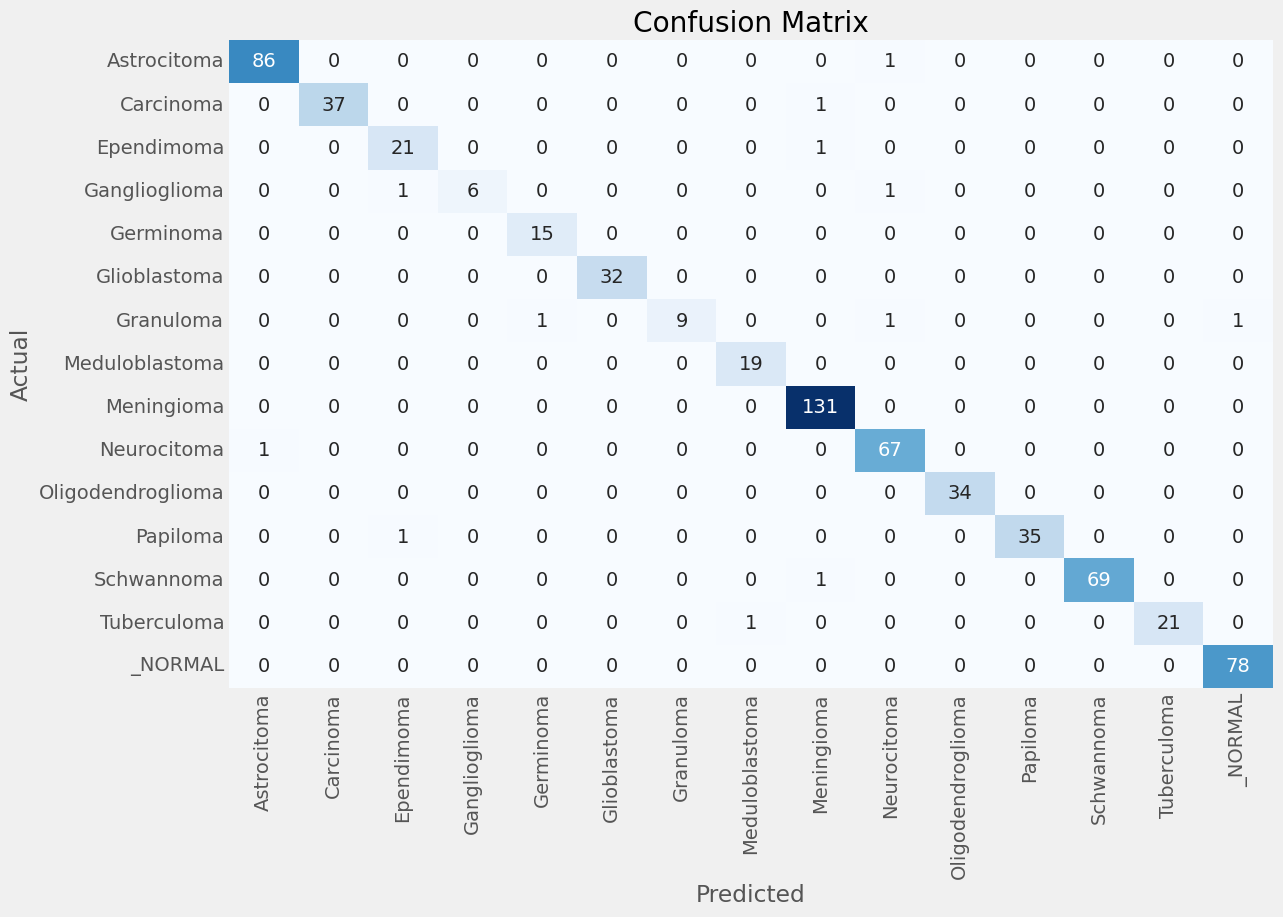

Classification Report:
----------------------
                    precision    recall  f1-score   support

      Astrocitoma     0.9885    0.9885    0.9885        87
        Carcinoma     1.0000    0.9737    0.9867        38
       Ependimoma     0.9130    0.9545    0.9333        22
    Ganglioglioma     1.0000    0.7500    0.8571         8
        Germinoma     0.9375    1.0000    0.9677        15
     Glioblastoma     1.0000    1.0000    1.0000        32
        Granuloma     1.0000    0.7500    0.8571        12
   Meduloblastoma     0.9500    1.0000    0.9744        19
       Meningioma     0.9776    1.0000    0.9887       131
      Neurocitoma     0.9571    0.9853    0.9710        68
Oligodendroglioma     1.0000    1.0000    1.0000        34
         Papiloma     1.0000    0.9722    0.9859        36
       Schwannoma     1.0000    0.9857    0.9928        70
      Tuberculoma     1.0000    0.9545    0.9767        22
          _NORMAL     0.9873    1.0000    0.9936        78

       

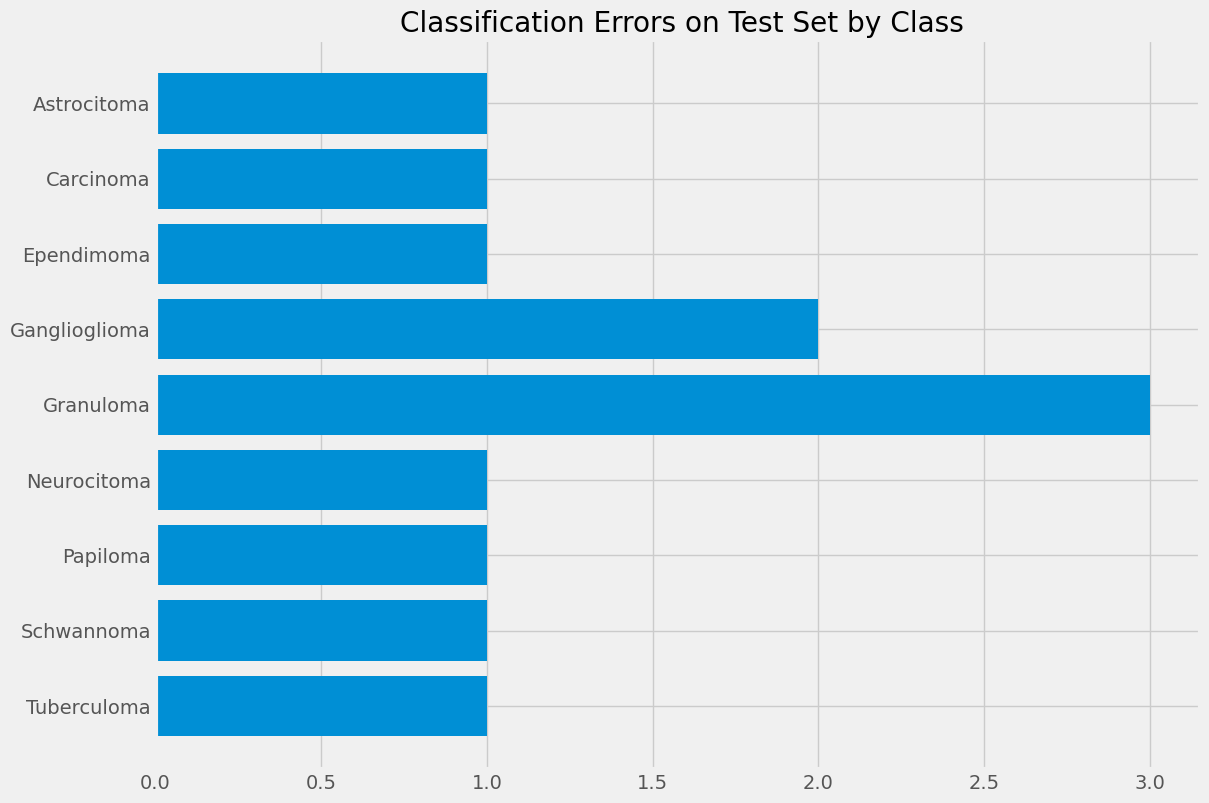

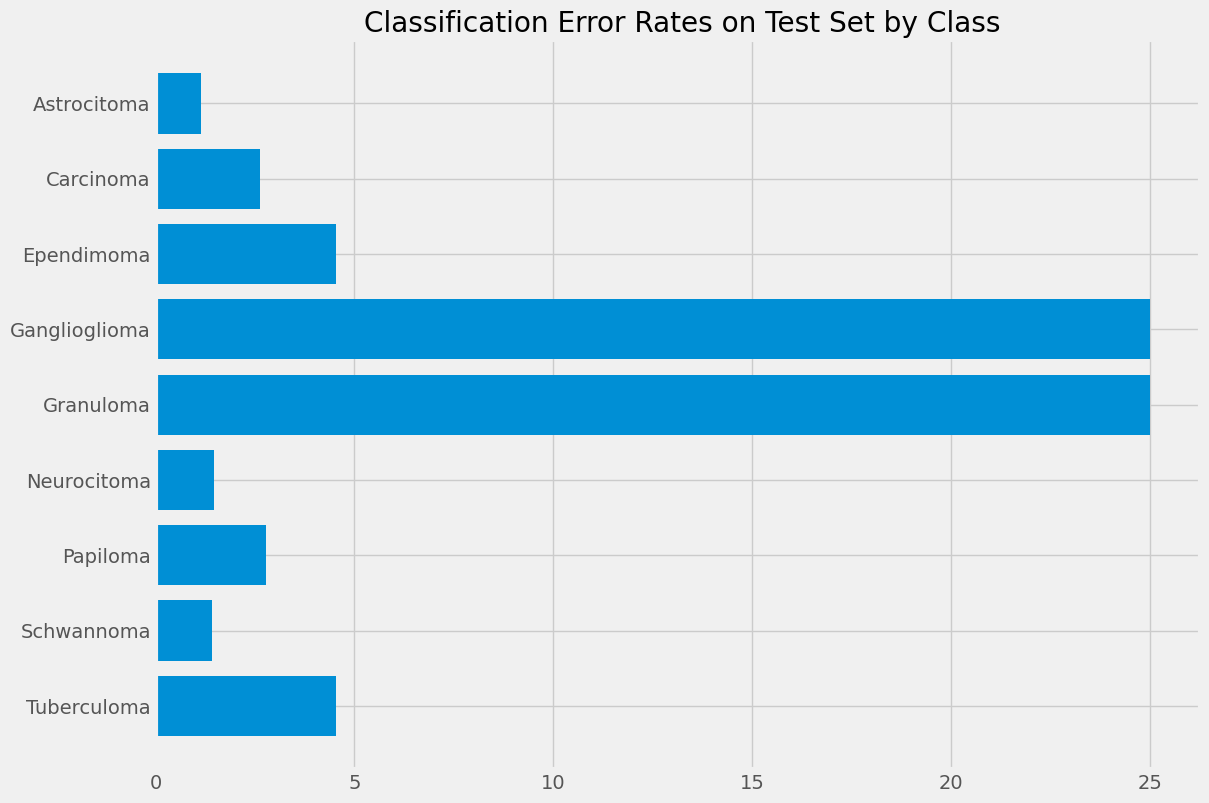

In [ ]:
delimiter = '/'
errors, tests, error_list, error_pred_list, f1score = predictor(ensemble_model3, test_gen)
print_errors(error_list, error_pred_list, delimiter)
error_classes, error_count = plot_errors_vs_class(error_list, delimiter)
print_error_rate(error_classes, error_count, test_df)

Model 44

In [ ]:
model1 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_32.h5", custom_objects={"F1_score": F1_score})
model2 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_34.h5", custom_objects={"F1_score": F1_score})
model3 = tf.keras.models.load_model("/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_39.h5", custom_objects={"F1_score": F1_score})
model1._name = "model_1"
model2._name = "model_2"
model3._name = "model_3"
models = [model1, model2, model3]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model4 = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model4.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', F1_score, 'AUC'])

In [ ]:
train_score = ensemble_model4.evaluate(train_gen, verbose= 1)
valid_score = ensemble_model4.evaluate(valid_gen, verbose= 1)
test_score = ensemble_model4.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train F1-score: ", train_score[2])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Validation F1-score: ", valid_score[2])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test F1-score: ", test_score[2])

12/12 [==============================] - 4s 336ms/step - loss: 0.4417 - accuracy: 0.9866 - F1_score: 0.9857 - auc: 0.9990
Train Loss:  0.3850977122783661
Train Accuracy:  1.0
Train F1-score:  1.0
--------------------
Validation Loss:  0.4075399935245514
Validation Accuracy:  0.9955357313156128
Validation F1-score:  0.9939035773277283
--------------------
Test Loss:  0.44170278310775757
Test Accuracy:  0.9866071343421936
Test F1-score:  0.9856932759284973


12/12 [==============================] - 13s 321ms/step
there were 9 errors in 672 tests for an accuracy of  98.66


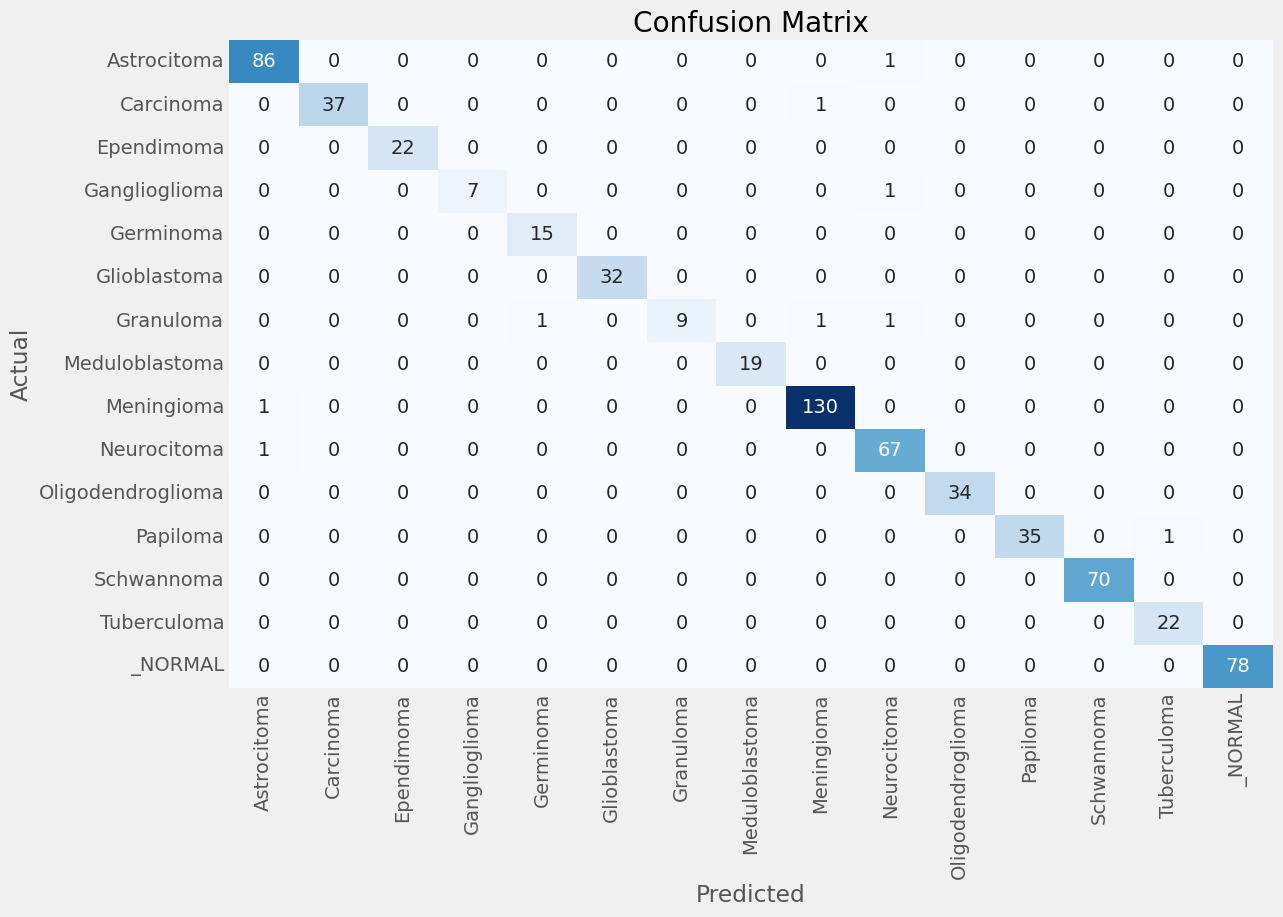

Classification Report:
----------------------
                    precision    recall  f1-score   support

      Astrocitoma     0.9773    0.9885    0.9829        87
        Carcinoma     1.0000    0.9737    0.9867        38
       Ependimoma     1.0000    1.0000    1.0000        22
    Ganglioglioma     1.0000    0.8750    0.9333         8
        Germinoma     0.9375    1.0000    0.9677        15
     Glioblastoma     1.0000    1.0000    1.0000        32
        Granuloma     1.0000    0.7500    0.8571        12
   Meduloblastoma     1.0000    1.0000    1.0000        19
       Meningioma     0.9848    0.9924    0.9886       131
      Neurocitoma     0.9571    0.9853    0.9710        68
Oligodendroglioma     1.0000    1.0000    1.0000        34
         Papiloma     1.0000    0.9722    0.9859        36
       Schwannoma     1.0000    1.0000    1.0000        70
      Tuberculoma     0.9565    1.0000    0.9778        22
          _NORMAL     1.0000    1.0000    1.0000        78

       

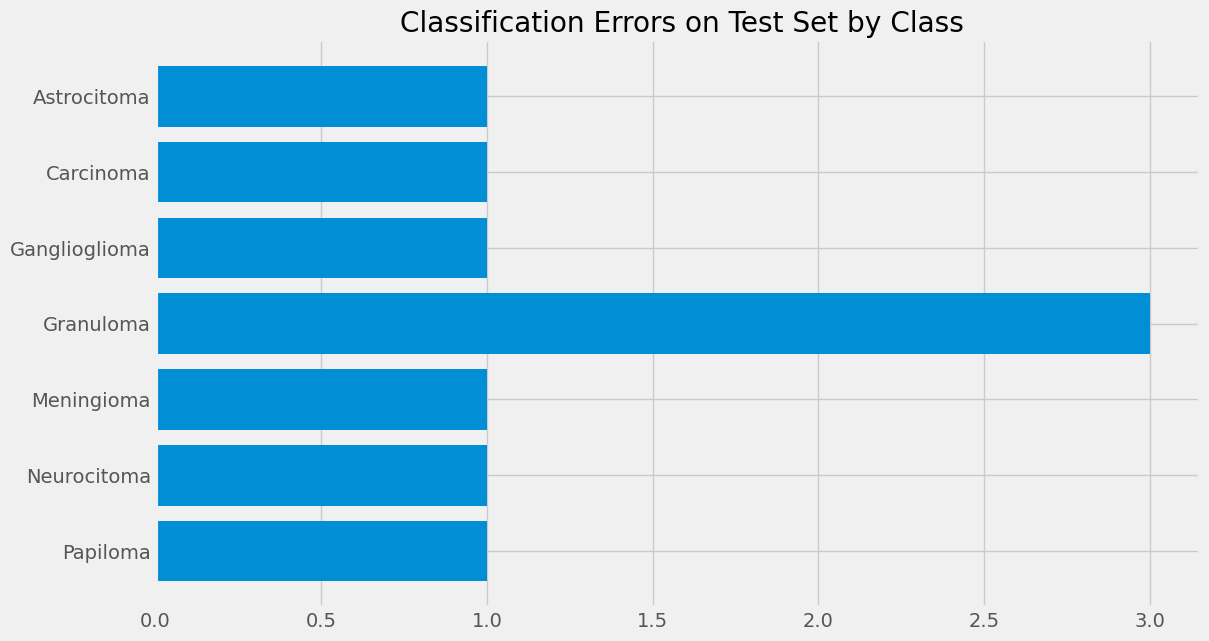

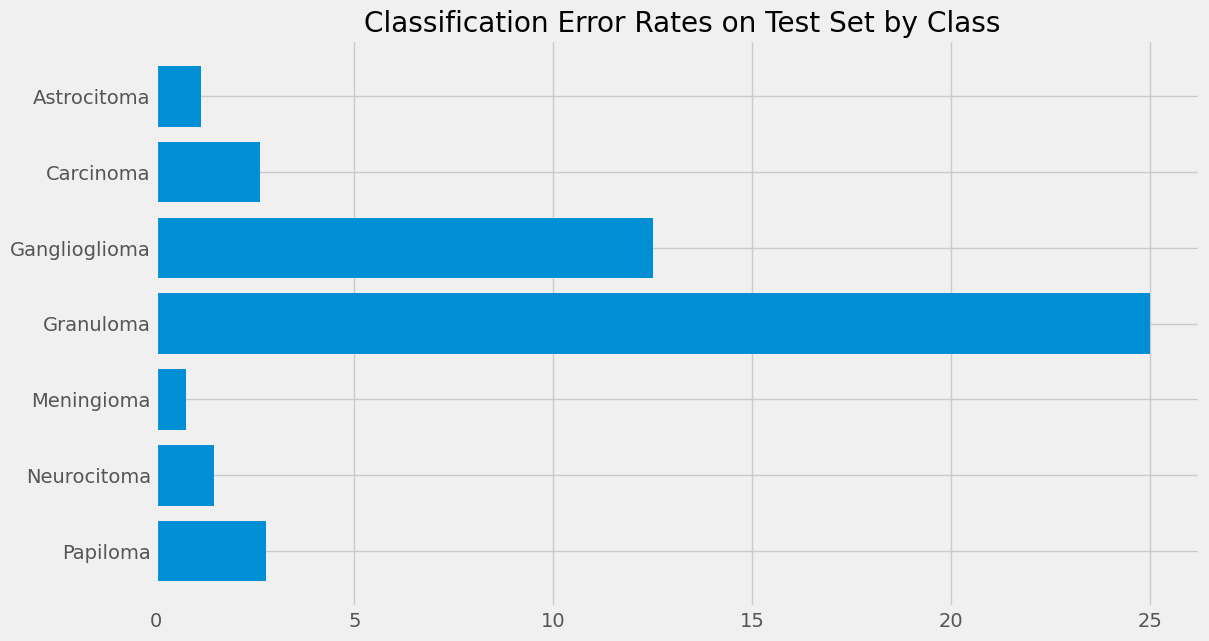

In [ ]:
delimiter = '/'
errors, tests, error_list, error_pred_list, f1score = predictor(ensemble_model4, test_gen)
print_errors(error_list, error_pred_list, delimiter)
error_classes, error_count = plot_errors_vs_class(error_list, delimiter)
print_error_rate(error_classes, error_count, test_df)